## Import

In [10]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary as summary
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import util

import warnings
warnings.filterwarnings(action='ignore') 

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [12]:
CFG = {
    'VIDEO_LENGTH':50, # 10프레임 * 5초
    'IMG_SIZE':(160, 90),
    'EPOCHS':20,
    'LEARNING_RATE':5e-5,
    'BATCH_SIZE':4,
    'SEED':41
}

## Fixed RandomSeed

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 학습 결과 Telegram으로 확인하기

In [14]:
import telegram as tel
import nest_asyncio 
import asyncio
nest_asyncio.apply()

async def sendmessage(text):
    bot = tel.Bot(token="6072572724:AAE9zqiw5E6aEx8r6dbo8kS370Eu130CGRQ")
    chat_id = 5726683275
    await bot.sendMessage(chat_id=chat_id, text=str(text))


## Data Load

In [15]:
df = pd.read_csv('./train.csv')

## Train / Validation Split

In [16]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

## Encoder / Decoder

In [17]:
encoder = [[[0 for _ in range(2)] for _ in range(3)] for _ in range(3)]
encoder[2][0][0] = 1
encoder[2][0][1] = 2
encoder[2][1][0] = 3
encoder[2][1][1] = 4
encoder[2][2][0] = 5
encoder[2][2][1] = 6
encoder[1][0][0] = 7
encoder[1][0][1] = 8
encoder[1][1][0] = 9
encoder[1][1][1] = 10
encoder[1][2][0] = 11
encoder[1][2][1] = 12

## CustomDataset

In [18]:
class CustomDataset(Dataset):
    def __init__(self, video_path_list, label_list, tfms):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.tfms = tfms
        
    def __getitem__(self, index):
        frames = self.get_video(self.video_path_list[index])
        
        if self.label_list is not None:
            label = self.label_list[index]
            label = np.array(label, dtype=np.int64)
            return frames, label
        else:
            return frames
        
    def __len__(self):
        return len(self.video_path_list)
    
    def get_video(self, path):
        frames = []
        cap = cv2.VideoCapture(path)
        for _ in range(CFG['VIDEO_LENGTH']):
            _, img = cap.read()
            frames.append(img)
        if self.tfms != None:
            frames = aug_video(frames, tfms=self.tfms)
        return np.transpose(frames, (3, 0, 1, 2))
    
def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return np.stack(aug_vid)

tfms_train = A.Compose([
            A.Resize(width=CFG['IMG_SIZE'][0], height=CFG['IMG_SIZE'][1]),
            A.Normalize(mean=(0.3192, 0.3201, 0.3083), std=(0.2132, 0.2072, 0.2059))
            ], p=1)

tfms_test = A.Compose([
            A.Resize(width=CFG['IMG_SIZE'][0], height=CFG['IMG_SIZE'][1]),
            A.Normalize(mean=(0.3192, 0.3201, 0.3083), std=(0.2132, 0.2072, 0.2059))
            ], p=1)

In [19]:
train_dataset = CustomDataset(train['video_path'].values, train[['crash_ego', 'weather', 'timing']].values, tfms=tfms_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['video_path'].values, val[['crash_ego', 'weather', 'timing']].values, tfms=tfms_test)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [40]:
train_dataset = CustomDataset(df['video_path'].values, None, tfms=tfms_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

color_sum = np.array([0., 0., 0.])
for i, x in enumerate(train_loader):
    x = x.numpy()
    color_sum += np.mean(x, axis=(0,2,3,4))
color_sum / len(train_loader)


array([-0.00025133, -0.00041374, -0.00043414])

In [22]:
color_mean = np.array([0, 0, 0])

for x,y in train_loader:
    x = x.permute(0, 2, 3, 4, 1).numpy()
    for vid in x:
        #_, ax = plt.subplots(1,5, figsize=(20,20))
        for i, pic in enumerate(vid):
            if i % 10 == 0:
                pic = np.stack([pic[:,:,2], pic[:,:,1], pic[:,:,0]], axis=-1)
                for i in range(3):
                    color_mean[i] += np.mean(pic[:,:,i])
                #ax[i//10].imshow(pic)
        #plt.show()
color_mean/ len(train_loader)

KeyboardInterrupt: 

ZeroDivisionError: float division by zero

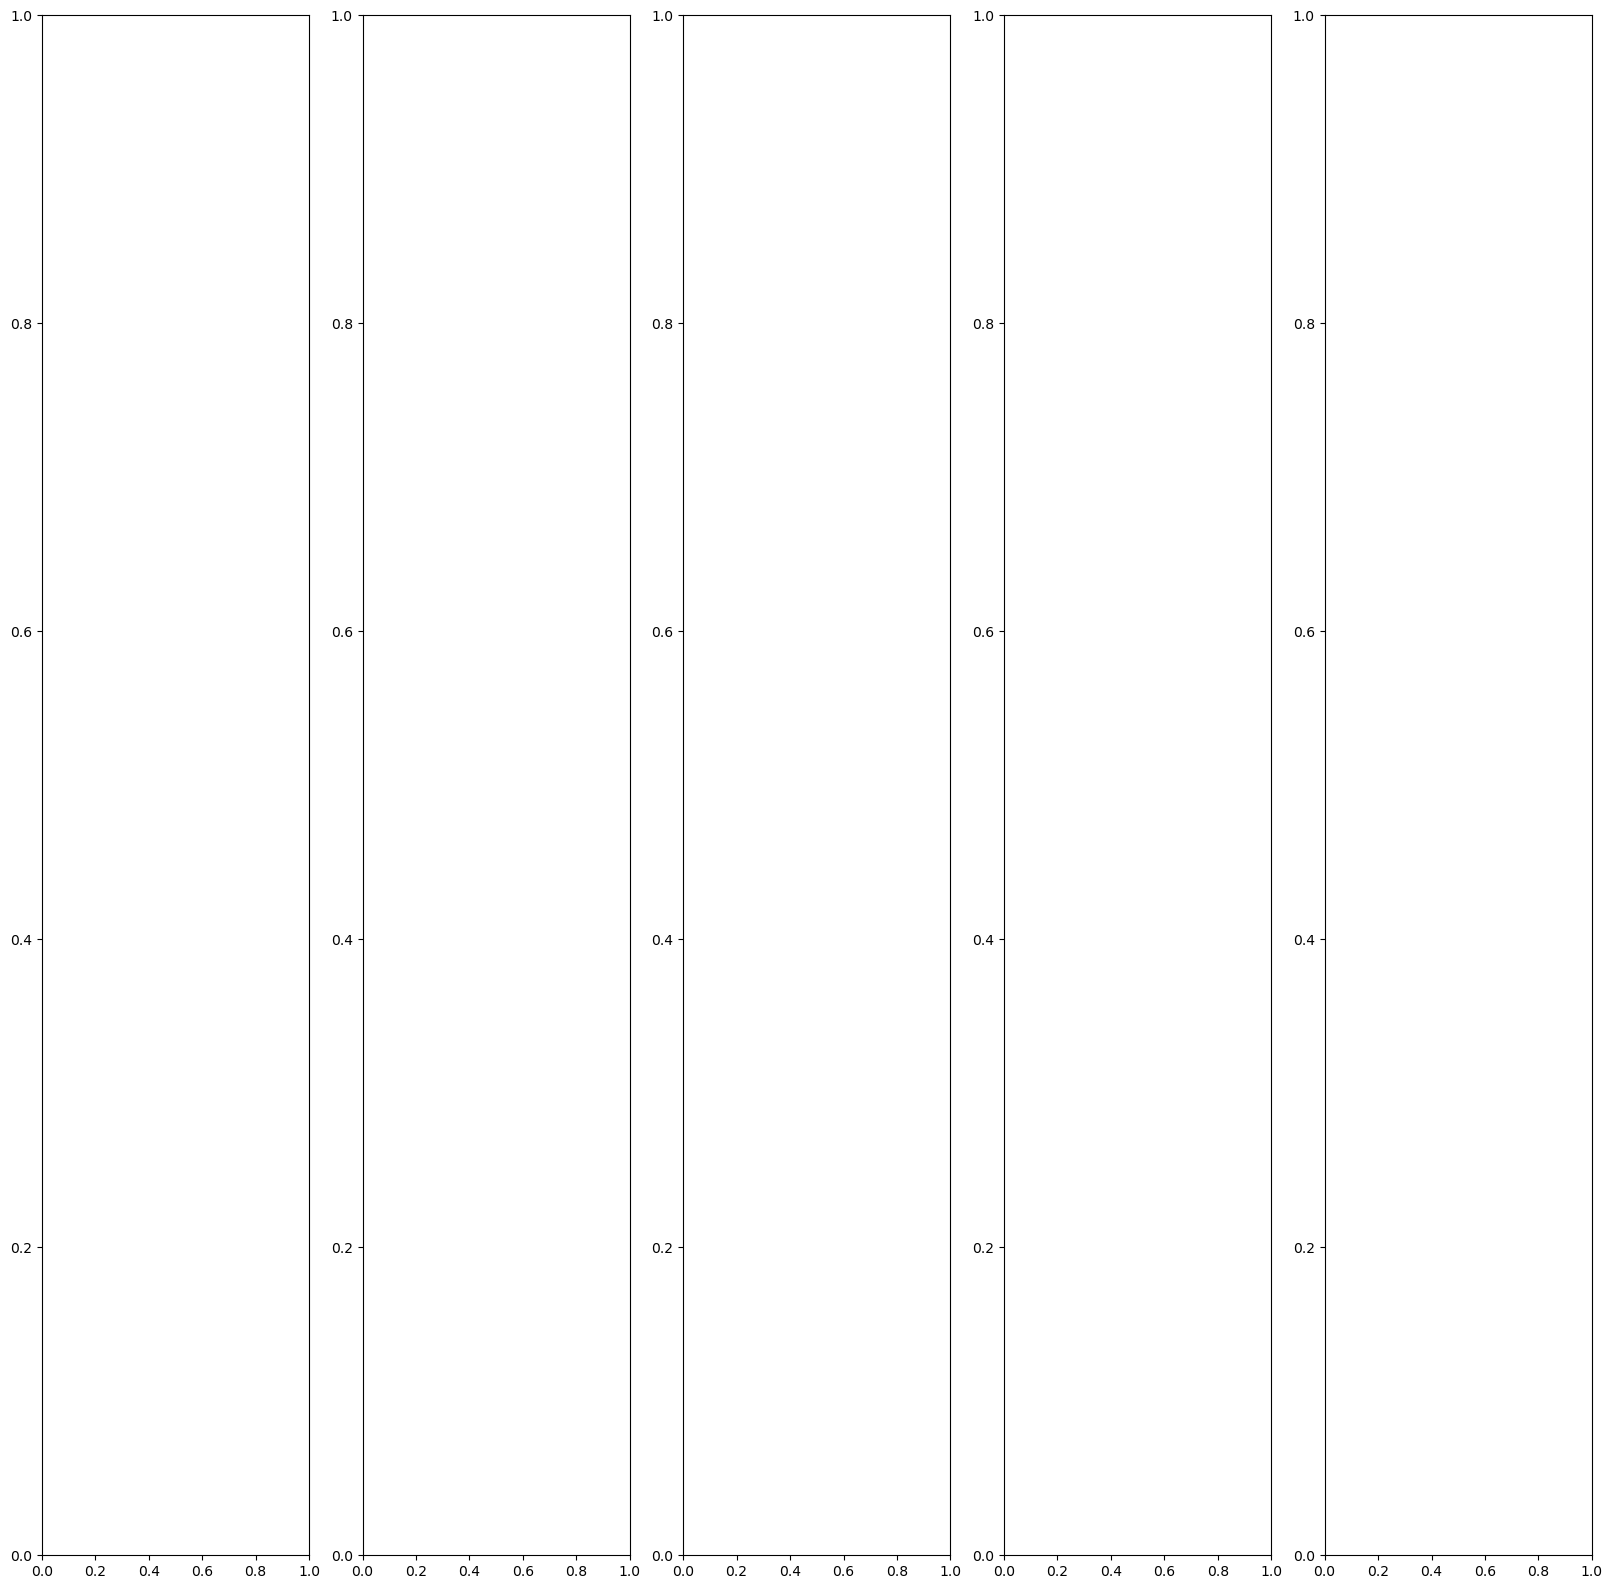

In [38]:
import torchvision.transforms as T
tfms_train = A.Compose([A.Resize(width=CFG['IMG_SIZE'][0], height=CFG['IMG_SIZE'][1]),
                        A.Affine(),
                        ], p=1)

train_dataset = CustomDataset(train['video_path'].values, train[['crash_ego', 'weather', 'timing']].values, tfms=tfms_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)


for x,y in train_loader:
    x = x.permute(0, 2, 3, 4, 1).numpy()
    for vid in x:
        _, ax = plt.subplots(1,5, figsize=(20,20))
        for i, pic in enumerate(seq(vid)):
            if i % 10 == 0:
                pic = np.stack([pic[:,:,2], pic[:,:,1], pic[:,:,0]], axis=-1)
                ax[i//10].imshow(pic)
        plt.show()

## Model Define

In [26]:
class R2Plus1D_18(nn.Module):
    def __init__(self, num_classes=13):
        super(R2Plus1D_18, self).__init__()
        self.pretrained_model = models.video.r2plus1d_18(weights=models.video.R2Plus1D_18_Weights)
        self.pretrained_model.fc = nn.Linear(512, 8)
        
    def forward(self, x):
        x = self.pretrained_model(x)
        return x

Layer (type:depth-idx)                   Output Shape              Param #
├─VideoResNet: 1-1                       [-1, 8]                   --
|    └─R2Plus1dStem: 2-1                 [-1, 64, 50, 45, 80]      --
|    |    └─Conv3d: 3-1                  [-1, 45, 50, 45, 80]      6,615
|    |    └─BatchNorm3d: 3-2             [-1, 45, 50, 45, 80]      90
|    |    └─ReLU: 3-3                    [-1, 45, 50, 45, 80]      --
|    |    └─Conv3d: 3-4                  [-1, 64, 50, 45, 80]      8,640
|    |    └─BatchNorm3d: 3-5             [-1, 64, 50, 45, 80]      128
|    |    └─ReLU: 3-6                    [-1, 64, 50, 45, 80]      --
|    └─Sequential: 2-2                   [-1, 64, 50, 45, 80]      --
|    |    └─BasicBlock: 3-7              [-1, 64, 50, 45, 80]      222,016
|    |    └─BasicBlock: 3-8              [-1, 64, 50, 45, 80]      222,016
|    └─Sequential: 2-3                   [-1, 128, 25, 23, 40]     --
|    |    └─BasicBlock: 3-9              [-1, 128, 25, 23, 40]     5

Layer (type:depth-idx)                   Output Shape              Param #
├─VideoResNet: 1-1                       [-1, 8]                   --
|    └─R2Plus1dStem: 2-1                 [-1, 64, 50, 45, 80]      --
|    |    └─Conv3d: 3-1                  [-1, 45, 50, 45, 80]      6,615
|    |    └─BatchNorm3d: 3-2             [-1, 45, 50, 45, 80]      90
|    |    └─ReLU: 3-3                    [-1, 45, 50, 45, 80]      --
|    |    └─Conv3d: 3-4                  [-1, 64, 50, 45, 80]      8,640
|    |    └─BatchNorm3d: 3-5             [-1, 64, 50, 45, 80]      128
|    |    └─ReLU: 3-6                    [-1, 64, 50, 45, 80]      --
|    └─Sequential: 2-2                   [-1, 64, 50, 45, 80]      --
|    |    └─BasicBlock: 3-7              [-1, 64, 50, 45, 80]      222,016
|    |    └─BasicBlock: 3-8              [-1, 64, 50, 45, 80]      222,016
|    └─Sequential: 2-3                   [-1, 128, 25, 23, 40]     --
|    |    └─BasicBlock: 3-9              [-1, 128, 25, 23, 40]     5

## Focal Loss

In [12]:
class FocalLoss(nn.Module):
  def __init__(self, weight=None, gamma=2, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.weight = weight
    self.gamma = gamma
    self.reduction = reduction

  def forward(self, input, target):
    ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
    pt = torch.exp(-ce_loss)
    focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
    return focal_loss

## Train

In [13]:
def calc_loss(output, labels, criterion):
    loss = 0
    for i, label in enumerate(labels):
        if label[0] == 0:
            loss += criterion(input = output[i][:3], target = F.one_hot(label[0], 3).to(torch.float64).to(device))
        else:
            loss += criterion(input = output[i][:3], target = F.one_hot(label[0], 3).to(torch.float64).to(device))
            loss += criterion(input = output[i][3:6], target = F.one_hot(label[1], 3).to(torch.float64).to(device))
            loss += criterion(input = output[i][6:8], target = F.one_hot(label[2], 2).to(torch.float64).to(device))
    loss /= len(labels)
    return loss

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    best_val_score = -1
    best_model = None
    criterion = nn.CrossEntropyLoss().to(device)

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(videos)
            loss = calc_loss(output, labels, criterion)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
                    
        _val_loss, _val_score, _val_acc = validation(model, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}], Val ACC : [{_val_acc:.5f}]')
        asyncio.run(sendmessage(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}], Val ACC : [{_val_acc:.5f}]'))
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = copy.deepcopy(model)
            best_model.to('cpu')
    
    return best_model

In [14]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    criterion = nn.CrossEntropyLoss().to(device)
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            output = model(videos)
            
            loss = calc_loss(output, labels, criterion)
            val_loss.append(loss.item())
            output = output.to('cpu').numpy()
            pred = np.stack([np.argmax(output[:, :3], axis=1),
                             np.argmax(output[:, 3:6], axis=1),
                             np.argmax(output[:, 6:8], axis=1)], axis=1)
            preds += list(pred)
            trues += list(labels.to('cpu').numpy())

        _val_loss = np.mean(val_loss)

    preds_encoded = list(map(lambda x: encoder[x[0]][x[1]][x[2]], preds))
    trues_encoded = list(map(lambda x: encoder[x[0]][x[1]][x[2]], trues))

    _val_acc = np.mean(np.array(preds_encoded) == np.array(trues_encoded))
    _val_score = f1_score(trues_encoded, preds_encoded, average='macro')
    visualize(trues, preds, trues_encoded, preds_encoded)
    return _val_loss, _val_score, _val_acc

def visualize(trues, preds, trues_encoded, preds_encoded):
    trues = np.array(trues)
    preds = np.array(preds)
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    print(ax)
    cm = confusion_matrix(y_true=trues[:,0], y_pred=preds[:,0], labels=[0, 1, 2], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no crash', 'crash', 'crash+ego'])
    disp.plot(ax=ax[0][0], cmap='Blues', colorbar=False)

    cm = confusion_matrix(y_true=trues[:,1][trues[:,0] != 0], y_pred=preds[:,1][trues[:,0] != 0], labels=[0, 1, 2], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'snowy', 'rainy'])
    disp.plot(ax=ax[0][1], cmap='Blues', colorbar=False)

    cm = confusion_matrix(y_true=trues[:,2][trues[:,0] != 0], y_pred=preds[:,2][trues[:,0] != 0], labels=[0, 1], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['day', 'night'])
    disp.plot(ax=ax[1][0], cmap='Blues', colorbar=False)

    trues_encoded = np.array(trues_encoded)
    preds_encoded = np.array(preds_encoded)
    
    cm = confusion_matrix(y_true=trues_encoded, y_pred=preds_encoded, labels=list(range(13)), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(13)))
    disp.plot(ax=ax[1][1], cmap='Blues', colorbar=False)
    plt.show()

## Run!!

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


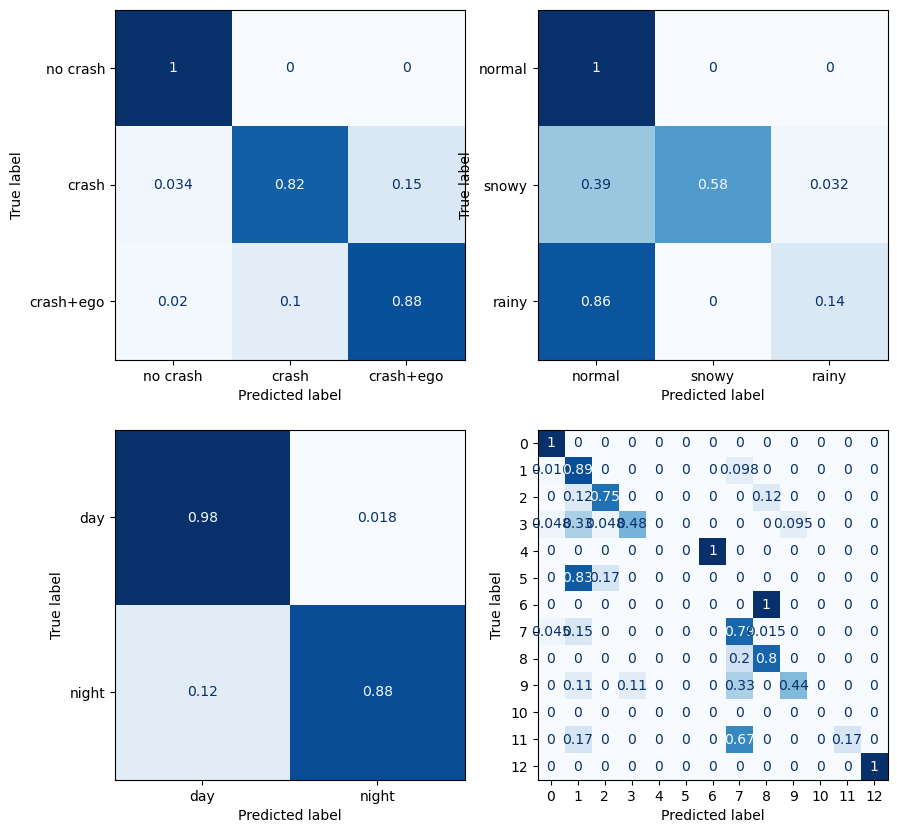

Epoch [1], Train Loss : [0.70761] Val Loss : [0.32735] Val F1 : [0.53468], Val ACC : [0.90185]


  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


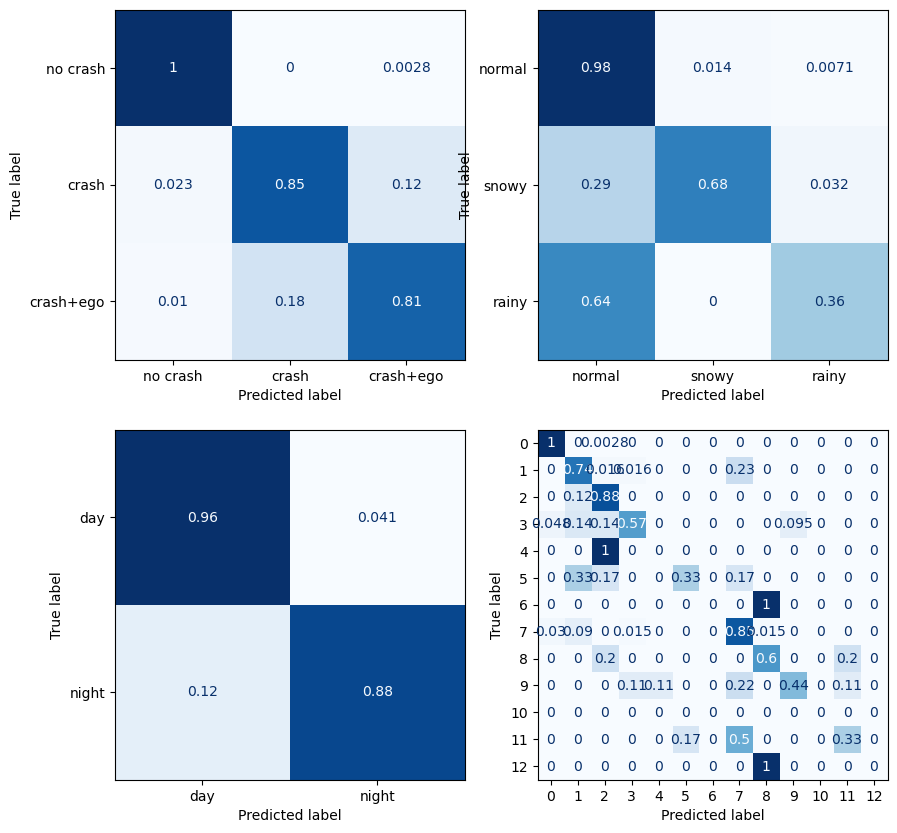

Epoch [2], Train Loss : [0.42295] Val Loss : [0.34435] Val F1 : [0.47894], Val ACC : [0.89815]


  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


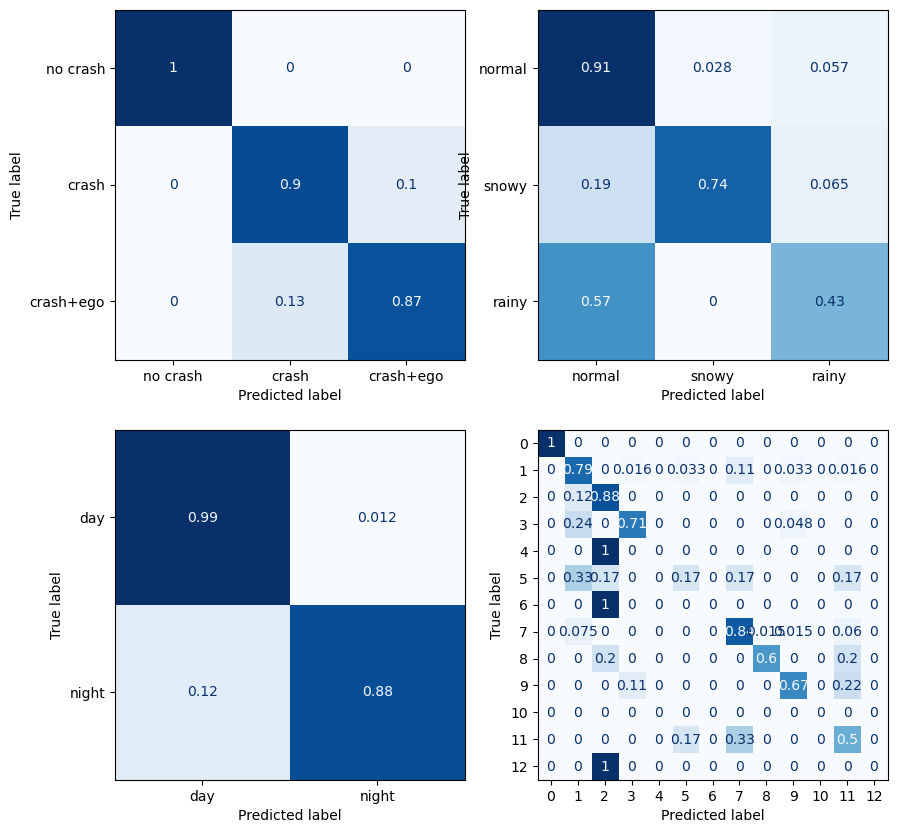

Epoch [3], Train Loss : [0.27339] Val Loss : [0.29395] Val F1 : [0.49584], Val ACC : [0.91296]


  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


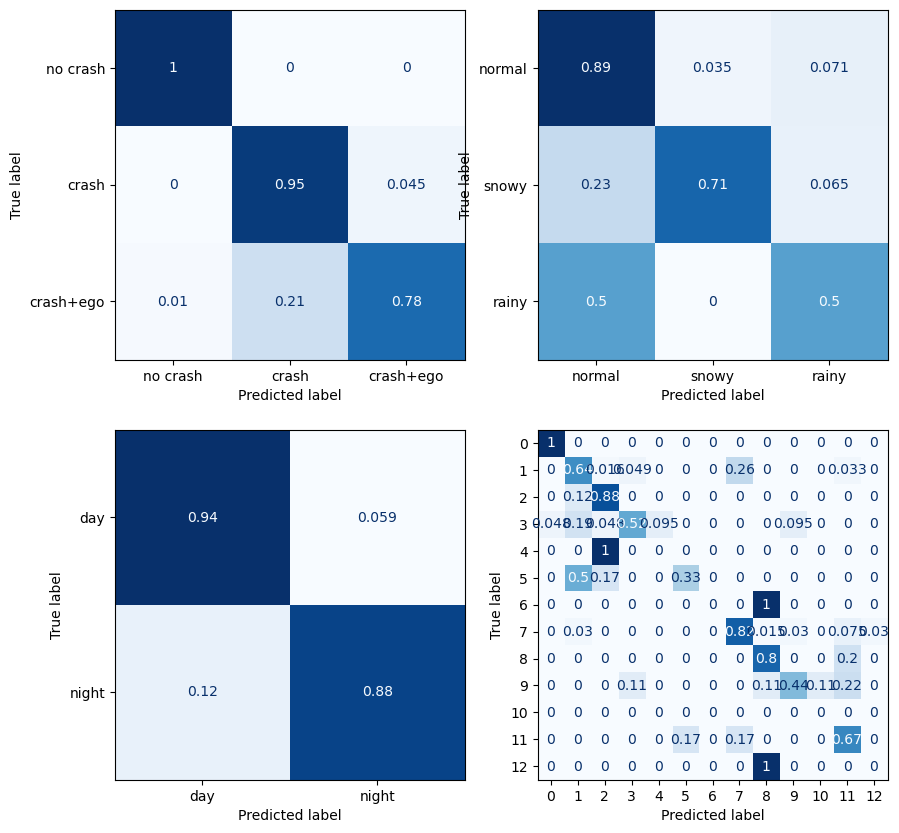

Epoch [4], Train Loss : [0.21872] Val Loss : [0.34140] Val F1 : [0.44442], Val ACC : [0.88889]
Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/540 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
model = R2Plus1D_18()
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)
validation(model = infer_model, val_loader = val_loader, device = device)
torch.save(model.state_dict(), 'model.pth')

In [ ]:
torch.save(model.state_dict(), 'model.pth')
torch.save(infer_model.state_dict(), 'infer_model.pth')

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)
            output = model(videos)
            output = output.to('cpu').numpy()
            pred = np.stack([np.argmax(output[:, :3], axis=1),
                             np.argmax(output[:, 3:6], axis=1),
                             np.argmax(output[:, 6:8], axis=1)], axis=1)
            preds += list(pred)
    return list(map(lambda x: encoder[x[0]][x[1]][x[2]], preds)), np.array(preds)

In [ ]:
test_dataset = util.CustomDataset(df['video_path'].values, None, tfms=tfms_test, CFG=CFG)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=4)
preds_encoded, preds = inference(model, test_loader, device)

  0%|          | 0/675 [00:00<?, ?it/s]

## Inference

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
test_dataset = util.CustomDataset(test['video_path'].values, None, tfms=tfms_test, CFG=CFG)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=4)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)
            output = model(videos)
            output = output.to('cpu').numpy()
            pred = np.stack([np.argmax(output[:, :3], axis=1),
                             np.argmax(output[:, 3:6], axis=1),
                             np.argmax(output[:, 6:8], axis=1)], axis=1)
            preds += list(pred)
    return list(map(lambda x: encoder[x[0]][x[1]][x[2]], preds))

In [ ]:
preds = inference(model, test_loader, device)

  0%|          | 0/450 [00:00<?, ?it/s]

In [ ]:
infer_model.to(device)
preds_infer = inference(infer_model, test_loader, device)

  0%|          | 0/450 [00:00<?, ?it/s]

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit_infer = copy.deepcopy(submit)

In [ ]:
submit['label'] = preds
submit_infer['label'] = preds_infer
submit.head()

,sample_id,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [ ]:
import shutil
from datetime import datetime

current_time = datetime.now()
time = str(current_time.strftime("%m_%d %H_%M_%S"))
if not os.path.isdir('history'):
    os.mkdir('history')

if not os.path.isdir(os.path.join('history', time)):
    os.mkdir(os.path.join('history', time))

shutil.copyfile("./[Baseline]_간단한 Conv3d를 활용한 비디오(동영상) 분류 모델.ipynb", f"./{os.path.join('history', time)}/[Baseline]_간단한 Conv3d를 활용한 비디오(동영상) 분류 모델.ipynb")
submit.to_csv(f"./{os.path.join('history', time)}/submit {time}.csv", index=False)
submit_infer.to_csv(f"./{os.path.join('history', time)}/submit infer {time}.csv", index=False)
shutil.copyfile("./model.pth", f"./{os.path.join('history', time)}/model.pth")
shutil.copyfile("./infer_model.pth", f"./{os.path.join('history', time)}/infer_model.pth")

'./history\\02_15 14_20_48/infer_model.pth'